<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/LAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Tewabe Melkamu

Date: 3/13/2025

LAI_Data Collection

In [1]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-melkatewabe')

In [5]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the USDOS/LSIB_SIMPLE/2017 dataset.
# If Taiwan is not available in this dataset, consider an alternative source.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# Load the first image from ESA WorldCover and clip it to Taiwan.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# Class definitions from ESA WorldCover:
# 50 = Built-up, 80 = Permanent water bodies.
# We remove both built-up and permanent water by keeping pixels that are not 50 and not 80.
mask = worldcover.neq(50).And(worldcover.neq(80))

# Create an interactive map (optional).
#Map = geemap.Map(center=[23.5, 121], zoom=7)

# -------------------------------------------------------------------
# 3. Loop through each year from 2004 to 2024 and export the yearly mean LST
# -------------------------------------------------------------------
for year in range(2000, 2002):
    print(f"Processing year: {year}")

    # Define the date range for the year.
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    # Compute the mean LST image for the year using the MODIS LST (MODIS/061/MOD11A1).
    LAI= (ee.ImageCollection("MODIS/061/MCD15A3H")
                .filterDate(start_date, end_date)
                .filterBounds(taiwan)
                .select('Lai')
                .mean()
                .clip(taiwan))

    # Multiply by 0.02 to convert the raw values to Kelvin.
    LAI_s = LAI.multiply(0.1)

    # Apply the mask.
    LAI_masked = LAI_s.updateMask(mask)

    # Define and start the export task.
    task = ee.batch.Export.image.toDrive(
        image=LAI_masked,
        description=f'LAI_{year}',
        folder='Taiwan_LAI',  # Update this to your desired Drive folder.
        fileNamePrefix=f'LAI_{year}',
        region=taiwan.geometry().bounds().getInfo()['coordinates'],
        scale=1000,  # MODIS resolution is approximately 1 km.
        crs='EPSG:32651',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for {year} started. Please check your GEE tasks and Google Drive.")

# Optionally, display the interactive map.
#Map

Processing year: 2000
Export task for 2000 started. Please check your GEE tasks and Google Drive.
Processing year: 2001
Export task for 2001 started. Please check your GEE tasks and Google Drive.


In [ ]:
# 1. Define Ethiopia's boundary using a FeatureCollection.
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
ethiopia = countries.filter(ee.Filter.eq('country_na', 'Ethiopia'))

# 2. Load the MODIS LAI dataset (MOD15A2H), filter by date (2020) and by location (Ethiopia).
dataset = ee.ImageCollection('MODIS/061/MCD15A3H') \
    .filter(ee.Filter.date('2020-01-01', '2020-12-31')) \
    .filterBounds(ethiopia.geometry())

# Select the LAI band, compute the mean over the time period, and clip to Ethiopia.
lai = dataset.select('Lai').mean().clip(ethiopia.geometry())

# Multiply by 0.1 to convert the raw LAI values to physical units.
LAI_1km = lai.multiply(0.1)

# 3. Create a mask to remove water bodies.
# Load ESA WorldCover and clip to Ethiopia.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(ethiopia)
# In ESA WorldCover, class 80 represents permanent water bodies.
mask = worldcover.neq(80)
# Apply the water body mask to the LAI image.
LAI_masked = LAI_1km.updateMask(mask)

# 4. Visualization parameters for LAI.
# Typically, LAI values range from 0 to around 6 in many ecosystems.
LAI_vis = {
    'min': 0,
    'max': 6,
    'palette': ['white', 'lightgreen', 'green']
}

# 5. Create an interactive map centered on Ethiopia.
Map = geemap.Map(center=[9.0, 40.0], zoom=6)
Map.addLayer(LAI_masked, LAI_vis, 'Masked LAI')
Map.addLayer(ethiopia, {}, 'Ethiopia Boundary')
Map.addLayerControl()  # Enable layer control

# Display the map (in a Jupyter Notebook, the last statement will display the map)
Map


In [ ]:
# 6. Export the masked, yearly-mean NDWI image to Google Drive.
export_task = ee.batch.Export.image.toDrive(
    image=LAI_masked,
    description='LAI_2020',
    folder='DEM',
    fileNamePrefix='LAI_2020',
    region=ethiopia.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # Adjust scale (500 m is typical for MODIS products)
    crs='EPSG:32637',
    maxPixels=1e13
)
export_task.start()
print("export started")

export started


In [2]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.7 MB/s eta 0:00:00


Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


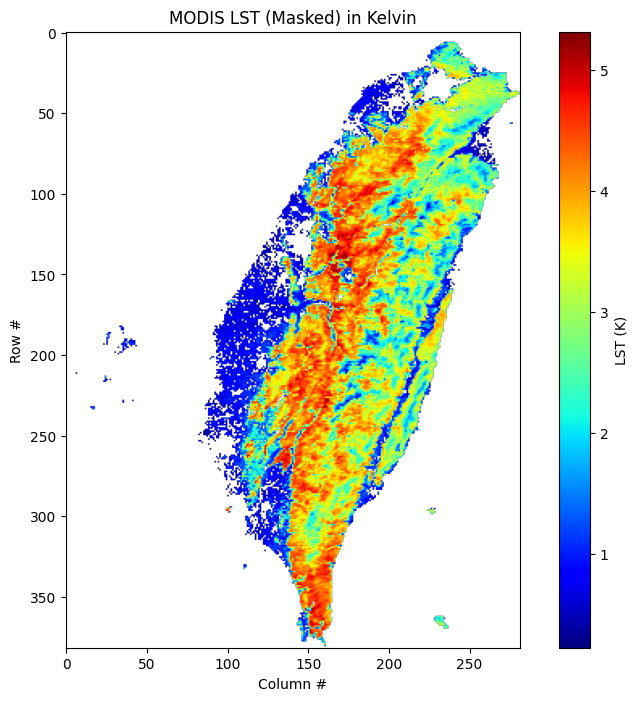

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/Taiwan_LAI/LAI_2024.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST (Masked) in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

